# Uncertainty Quantification

In [1]:
import numpy as np
import pandas as pd
from IPython.display import YouTubeVideo
from scipy import stats

import statsmodels.api as sm
import pymc as pm
import arviz as az
import bambi as bmb

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

# Turn off logging (console output) for PyMC
import logging
logging.getLogger("pymc").setLevel(logging.ERROR)

sns.set()

(Almost) every dataset we work with has some amount of uncertainty in it. Everything from the randomness in a sample, measurement error, differences between the data and the underlying truth they represent, and much more can lead to uncertainty. 

Therefore, anything we **compute** using the data also inherits some uncertainty. So, it's important to always report that uncertainty:
* If we infer a parameter or trend, we should report our uncertainty in the inference.
* If we make a prediction, we should report our uncertainty in the prediction.
* If we draw a conclusion, we should report our uncertainty in the conclusion.

While uncertainty quantification looks slightly different from frequentist and Bayesian perspectives, the core ideas above remain true regardless.

## Frequentist Uncertainty Quantification

In the frequentist setting, we treat our data as random, but our unknowns as fixed. So, any uncertainty we quantify is only over the data! We **cannot** make statements like "*The unknown is probably within*" or "*The probability of the parameter being..*".

While these statements can be more intuitive and might align with what we want to say when quantifying uncertainty, they only make sense in the context of a probability model for the unknown: we'll have to take a Bayesian approach in order to say anything of this sort.

The main way we'll quantify uncertainty in the frequentist setting is by using the distribution of our estimators. Specifically, whenever we estimate some parameter $\theta$ with an estimator $\hat{\theta} = f(x_1, \ldots, x_n)$, the estimator is random, because it depends on the random data (even if $\theta$ is fixed). So, we can use the distribution of $\hat{\theta}$ to quantify uncertainty.

We already know that if we have the distribution of $\hat{\theta}$, we can construct a **confidence interval**, which gives us an idea of how much our estimator could vary if we had observed different datasets. But before we can construct one, we need to determine the distribution for $\hat{\theta}$.

In [2]:
YouTubeVideo('ZDqSXtm0vBM')

### UQ with the Central Limit Theorem

*For more on the Central Limit Theorem, see [Chapter 14 of the Data 140 textbook](https://data140.org/textbook/content/Chapter_14/00_The_Central_Limit_Theorem.html).*

If we want to use the distribution of $\hat{\theta}$ to quantify our uncertainty, then we have to start by answering: "what is the distribution of $\hat{\theta}$?

In the case where $\theta$ is the sample mean, we can answer this with one of the most beautiful results in statistics: the **Central Limit Theorem**. Briefly, this states that if $\hat{\mu}$ is the sample mean of data points $x_1, \ldots, x_n$, where each $x_i$ has mean $\mu$ and (finite) variance $\sigma^2$, then the distribution of $\hat{\mu}$ converges to a normal distribution with mean $\mu$ and variance $\sigma^2/n$. 

Note that a similar result holds for any maximum likelihood estimate! While the details are beyond the scope of this class, one can show that if $\hat{\theta}_{MLE}$ is the maximum likelihood estimate for some parameter $\theta$ based on data points $x_1, \ldots, x_n$, then the distribution for $\hat{\theta}_{MLE}$ **also** converges to a normal distribution, with mean $\theta$ and variance $1/(nI(\theta))$. Here, $I(\theta)$ is the [Fisher informatoin](https://en.wikipedia.org/wiki/Fisher_information) of the likelihood, which quantifies how much information each $x_i$ gives us about $\theta$. 

While the details (e.g., Fisher information) are beyond the scope of this class, the takeaway is important: 

Asymptotically (i.e., as the number of observations gets very large), **the distribution of a maximum likelihood estimator, like that of a sample mean, converges to a normal distribution**.

In [3]:
YouTubeVideo('TiqwK0YYrNo')

### UQ with the Bootstrap

*You may find it helpful to review [Chapter 13.2 of the Data 8 textbook](https://inferentialthinking.com/chapters/13/2/Bootstrap.html), which covers the bootstrap.*

In many cases, we might not be able to compute the distribution of $\hat{\theta}$ analytically. In some of these cases, we can use the **bootstrap** to quantify uncertainty.

#### Bootstrap limitations

*Coming soon*

The bootstrap works well in most, but not all situations. Here are some guidelines for when to (and when not to) use it:
* The bootstrap is a **good** choice when the presence or absence of a single sample won't change the estimate dramatically (e.g., this is not true for the min or max)
* The bootstrap is a **good** choice when the number of data points is very small
* The bootstrap is a **good** choice when the number of parameters $d$ being estimated is much smaller than the number of data points $n$ (e.g., this is not true for neural networks, where we are estimating a very large number of parameters)

In [4]:
YouTubeVideo('hmQAc5VMBDY')

In [5]:
YouTubeVideo('ZQfrPKruYLg')

### Confidence intervals

*You may find it helpful to review [Section 13.3 of the Data 8 textbook](https://inferentialthinking.com/chapters/13/3/Confidence_Intervals.html), which covers confidence intervals.*

A confidence interval provides a measure of uncertainty about our estimator, based on its distribution. Recall that confidence intervals provide a guarantee about the process, not about the location of the (fixed) unknown parameter. Specifically, thinking about a 95% confidence interval, we know that 95% of datasets will produce an interval that contains the true parameter. We don't know whether our interval happens to be one of the lucky 95%, or one of the unlucky 5%.

In [6]:
YouTubeVideo('Zn9NqVID-qg')

### Uncertainty in GLMs: comparing coefficient and prediction intervals 

When quantifying uncertainty in GLMs, it's important to keep in mind that there are multiple sources of uncertainty. For example, consider our estimate of the coefficients, $\hat{\beta}$, computed from data $(x_1, y_1), \ldots, (x_n, y_n)$. These are computed as the maximum likelihood estimates given the observed data, and so have inherent uncertainty in them. In other words, if we had observed a different dataset, we might have gotten a different set of estimated coefficients $\hat{\beta}$.

Now, consider our estimated prediction for a new data point, $\hat{y}_{n+1}$. To simplify, we'll focus on linear regression with a scalar $x$. In this case, we can write the distribution for the new value $y_{n+1}$ as:
$$
\hat{y}_{n+1} \sim \mathcal{N}\left(\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}\,,\, \sigma^2\right)
$$
Here, there are two sources of uncertainty: (1) the uncertainty in our estimator for the coefficients, $\hat{\beta}$; and (2) the uncertainty in the observed value and how far away it'll be from the average prediction (i.e., prediction line), as quantified by $\sigma$.

So, if we want to construct a confidence interval for $\hat{\beta}_0$, we need only consider the first source of uncertainty. But, if we want to construct a confidence interval for $\hat{y}_{n+1}$, we need to consider **both** sources of uncertainty! This second type of interval is often called a **prediction interval**.

### Using Bootstrap to Quantify Uncertainty in GLMs

*Text coming soon: see video*

In [7]:
YouTubeVideo('73I1wfQfmf4')

## Bayesian Uncertainty Quantification

In the Bayesian setting, we treat our unknown parameters as random. This means that we can make statements like "The unknown is probably between A and B", which we couldn't in the frequentist setting. 

This motivates the definition of a **credible interval**. A $p\%$ credible interval for a parameter $\theta$, $(a, b)$, says that there is a $p\%$ chance that, given the observed data, the parameter $\theta$ falls between $a$ and $b$. For example, suppose we produce $90\%$ confidence interval for $\theta$ of $(0.3, 1.7)$. This tells us that given our observed data, the probability of $\theta$ being between 0.3 and 1.7 is $0.9$, or equivalently $\int_{0.3}^{1.7} p(\theta|x_1, \ldots, x_n) d\theta = 0.9$ (assuming $\theta$ is continuous).

Notice how much simpler this definition is than the confidence interval! This is one of the advantages of taking a Bayesian approach: treating our unknown as random lets us make intuitive statements about the probability that it takes on certain values.

In [8]:
YouTubeVideo('nGeZ7G34jPI')

However, one problem with this definition is that it is **not unique**! Indeed, there are many possible credible intervals for a given level of confidence/credibility. Consider the following distribution, and the three possible $80\%$ credible intervals. For all three, the total shaded blue area is $80\%$, so all three are valid $80\%$ credible intervals. Which one would you prefer?

![](credible_interval_comparison.png)

The one in the center seems the most appealing: it covers an area of highest density, and is also the narrowest. This motivates the definition of a **highest density interval (HDI)**, sometimes also called a highest posterior density (HPD) interval. The HDI is the narrowest interval for a given level of credibility/confidence.

*Exercise: is the HDI always unique? If not, then what constraints could we place on the posterior to ensure it's unique?*

We can see that the intervals we saw in Section 3.3 were HDIs that PyMC automatically constructed for us.

In [9]:
YouTubeVideo('8ozFH1ZN7Qw')

#### Constructing HDIs from samples

Given a posterior in closed form, we could analytically find $a$ and $b$ to minimize the width of the interval. But in practice, we rarely obtain posterior distributions in closed form: we usually end up approximating them with samples. So, how might we find an HDI with samples?

Let's do a simple example with some samples from a Beta-distributed random variable $t$:

Text(0, 0.5, 'p(t)')

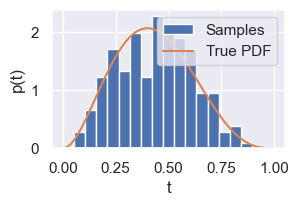

In [23]:
num_samples = 200
distribution = stats.beta(3, 4)
samples = distribution.rvs(num_samples)
f, ax = plt.subplots(1, 1, figsize=(3, 1.8))
t = np.linspace(0, 1, 100)
ax.hist(samples, bins=np.linspace(0, 1, 20), density=True, label='Samples')
ax.plot(t, distribution.pdf(t), label='True PDF')
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('p(t)');

Call the samples $\theta_1, \ldots, \theta_{100}$. We can construct a $90\%$ credible interval by sorting the samples, choosing any $i$ and $j$ so that $(j-i)/200 = 0.9$, and reporting $[\theta_i, \theta_j]$:

In [11]:
sorted_samples = np.sort(samples)
(i1, j1) = (10, 190)
(i2, j2) = (15, 195)
credible_interval_1 = (sorted_samples[i1], sorted_samples[j1])
credible_interval_2 = (sorted_samples[i2], sorted_samples[j2])
print(credible_interval_1)
print(credible_interval_2)

(0.13897427248823163, 0.6909690646340457)
(0.1546092668770565, 0.7253561061154236)


How can we find the HDI? We can simply search over all intervals of width $200 \times 0.9 = 180$, and find the narrowest one.

In [12]:
credibility = 0.9
narrowest_start_so_far = -1
narrowest_width_so_far = np.inf
interval_samples = int(num_samples * credibility)
for start in range(20): # Make sure you understand why we can stop at 20!
    end = start + interval_samples
    width = sorted_samples[end] - sorted_samples[start]
    if width < narrowest_width_so_far:
        narrowest_start_so_far = start
        narrowest_width_so_far = width
print((
    sorted_samples[narrowest_start_so_far],  
    sorted_samples[narrowest_start_so_far + interval_samples]
))

(0.12456744708291805, 0.6739146167781714)


### Bayesian UQ for Predictions

Just as in the frequentist world, in Bayesian GLMs, we can also construct credible intervals for our predictions! These will be constructed using the posterior predictive density, and inherit the uncertainty in the inference for the unknown coefficients as well as the uncertainty in the inference for parameters like $\sigma$ in linear regression.

In [13]:
YouTubeVideo('9wtfEgpIn8k')